In [1]:
import sys
sys.path.append("..")

In [2]:
from utiltis import read_img
from matplotlib import pyplot as plt
import numpy as np
import cv2

# img = cv2.imread('../pics/test3_r.jpg', 0)
# img = cv2.imread('../pics/test4_r.jpg', 0)
img = cv2.imread('../pics/test5c_r.jpg', 0)

## First step -- Prepocessing
### 1. Template matching to locate the detection area


In [39]:
import heapq

r = heapq.nlargest(3, matched.ravel())

np.where(matched==r[2])


(array([320]), array([18]))

## OTSU binary proc test


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f77636e9410>)

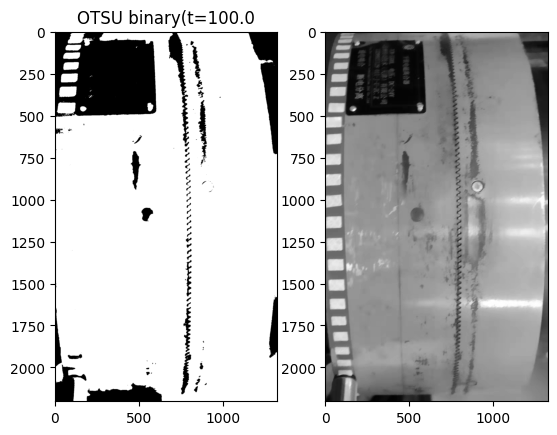

In [121]:
from thr_binary import OTUSBinary, AdaBinary

proc = OTUSBinary(img)
tval, res = proc()
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title(f'OTSU binary(t={tval}')
plt.subplot(122),plt.imshow(img,cmap = 'gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f7762d83890>)

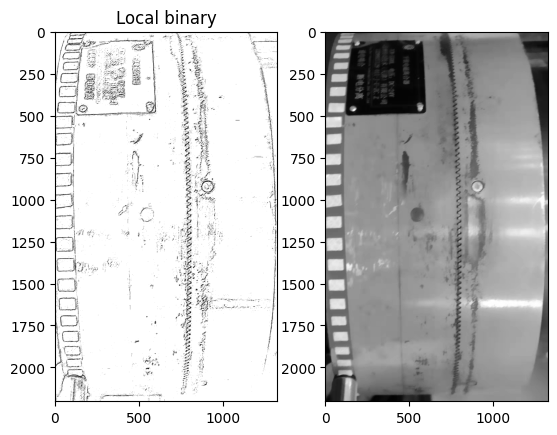

In [123]:
from thr_binary import AdaBinary

proc = AdaBinary(img)
# res = proc(bin_inv=True) # res can be "selected" only from 0 or 255
res = proc()
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Local binary')
plt.subplot(122),plt.imshow(img,cmap = 'gray')

## Morphy process mid-try

In [81]:
len([])

0

In [117]:
def ada_morphimg(img, remain_rate=.5, abs_zero_thres=100, pre_erode=True, post_dialate=True, max_ksize=7, inv=False, use_thres=True, tan_thres=10, tan_ratio=1.2):
    ksize = max_ksize
    zero_thres = np.sum(img>0)*remain_rate if inv else np.sum(img==0)*remain_rate
    # whiten_thres = np.sum(img>0)*(1-remain_rate) + remain_rate*img.size

    if pre_erode:
        img = cv2.erode(img, kernel=np.ones((ksize, ksize), np.uint8))
    
    px, py, ptanv = 0, 0, 0
    while True:
        new_img = cv2.dilate(img, np.ones((ksize, ksize)))

        if use_thres and np.sum(new_img==0)<zero_thres:
            break

        x, y = np.where(new_img==0); N = len(x)
        if N < abs_zero_thres:
            break
        x, y = (x.sum()/N, y.sum()/N)

        if px+py!=0:
            deltas = [abs(x-px), abs(y-py)]
            tanv = max(deltas)/min(deltas)
            if tanv >= tan_thres or tanv < ptanv:
                break
            if ptanv and tanv > ptanv*tan_ratio:
                ksize = max(3, ksize-2)
            ptanv = tanv

        px, py, img = x, y, new_img
    
    if post_dialate:
        ksize = max(3, ksize-2)
        img = cv2.dilate(img, np.ones((ksize, ksize)))
    else:
        img = new_img
        
    try:
        return img, (x, y, tanv)
    except UnboundLocalError:
        return img, (x, y)
    


In [128]:
morphed, mvals = ada_morphimg(res, remain_rate=.2)
print(mvals)

(816.3405664148584, 561.9993132501717, 29.081532494015935)


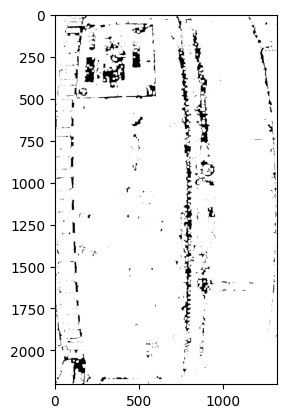

In [129]:
plt.imshow(morphed, cmap='gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f77628fe650>)

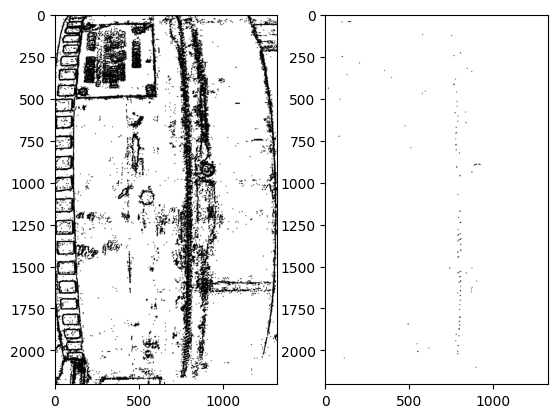

In [132]:
eimg = cv2.erode(res, kernel=np.ones((5, 5), np.uint8), iterations=1)
# plt.imshow(eimg, cmap='gray')
from morph import ImgClosing, ImgDilate

proc = ImgClosing(res)
morphed_img = proc(ksize=3, iters=2)
# proc = ImgDilate(eimg)
# morphed_img = proc(ksize=3, iters=5)
plt.subplot(121), plt.imshow(eimg, cmap='gray')
plt.subplot(122), plt.imshow(morphed_img, cmap='gray')

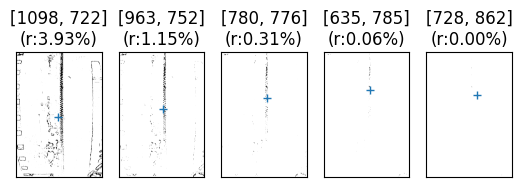

In [73]:
def get_midpoint(img):
    x, y = np.where(img==0)
    N = len(x)
    return x.sum()/N, y.sum()/N if not np.isnan(x) else (0, 0)

iters = 5
mplist = []
mimg= cv2.erode(res, kernel=np.ones((5, 5), np.uint8), iterations=1)
for i in range(iters):
    mimg = cv2.dilate(mimg, np.ones((5, 5)))
    x, y = np.where(mimg==0); N = len(x)
    mpoint = (x.sum()/N, y.sum()/N) if N!=0 else (0, 0)
    mplist.append(mpoint[::-1])

    plt.subplot(int(f'1{iters}{i+1}')), plt.imshow(mimg, cmap='gray')
    plt.plot(*mpoint[::-1], marker='+'), plt.title(f'{[int(x) for x in mpoint]}\n(r:{100*np.sum(mimg==0)/mimg.size:.2f}%)')
    plt.xticks([]), plt.yticks([])
    

In [78]:
mplist = np.array(mplist)

np.apply_along_axis(lambda m: np.convolve(m, [1, -1], mode='valid'), axis=0, arr=mplist)

array([[  30.02574677, -134.73138116],
       [  23.88087564, -183.47111985],
       [   8.90468541, -145.18014713],
       [  77.36814164,   93.5619739 ]])

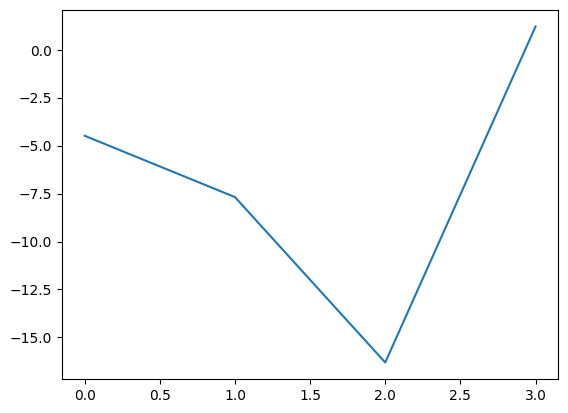

In [79]:
mplist = np.array(mplist)
tanv = np.apply_along_axis(lambda m: np.convolve(m, [1, -1], mode='valid'), axis=0, arr=mplist)

tanv = tanv[:, 1]/tanv[:, 0]
plt.plot(tanv)

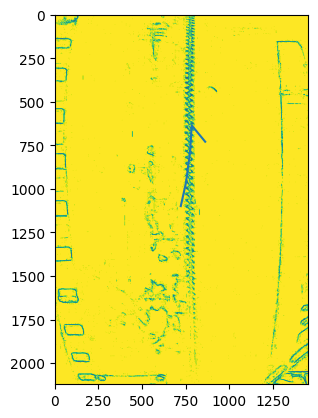

In [69]:
plt.imshow(res)
plt.plot(*np.array(mplist).T)

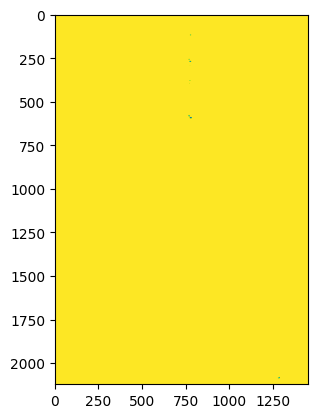

In [66]:
plt.imshow(mimg)

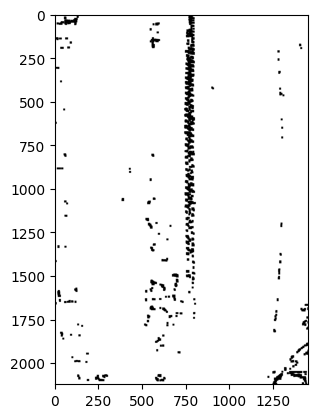

In [22]:
plt.imshow(morphed_img, cmap='gray')

In [24]:
x, y = np.where(morphed_img==0)

In [28]:
x.sum()/98987

1053.2628729025023

In [55]:
np.sum(res>0), np.sum(mimg>0), res.shape[0]*res.shape[1]

(3027586, 3087367, 3087510)

## Sobel detection mid-try

(<AxesSubplot:title={'center':'sboel-y'}>,
 Text(0.5, 1.0, 'sboel-y'))

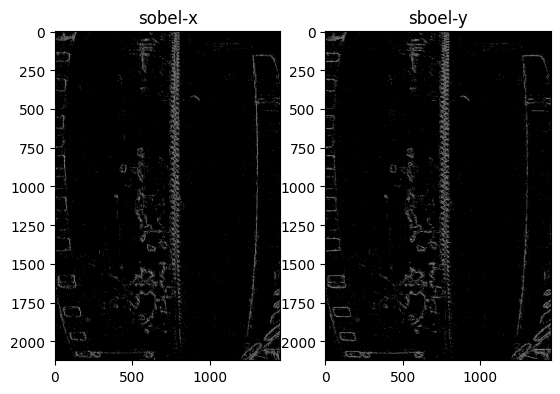

In [21]:
# `res` is a threshold-binary image
sobelx = cv2.Sobel(res, -1, 1, 0, ksize=3)
sobely = cv2.Sobel(res, -1, 0, 1, ksize=3)
plt.subplot(121),plt.imshow(sobelx,cmap = 'gray'), plt.title('sobel-x')
plt.subplot(122),plt.imshow(sobely,cmap = 'gray'), plt.title('sboel-y')

In [16]:
np.all((res==0) | (res==255))

True

In [34]:
img = cv2.imread('../pics/test3_r.jpg', 0)

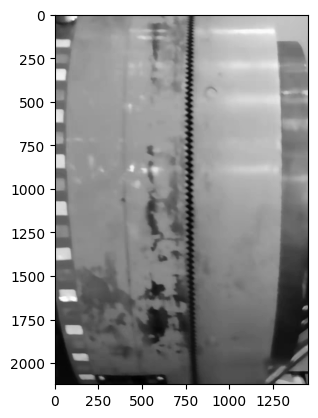

In [35]:
plt.imshow(img, cmap='gray')

In [45]:
temp = np.array([[0, 1, 0], [0, 1, 1], [0, 1, 0]]).astype(np.uint8)
# temp = np.array([[1, 0, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 0], [1, 0, 0, 0]]).astype(np.uint8)
# temp = np.array([[255, 255, 0], [255, 255, 255], [255, 255, 0]]).astype(np.float32)
res = cv2.matchTemplate(img, temp, cv2.TM_CCOEFF_NORMED)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fd4cbbf7450>)

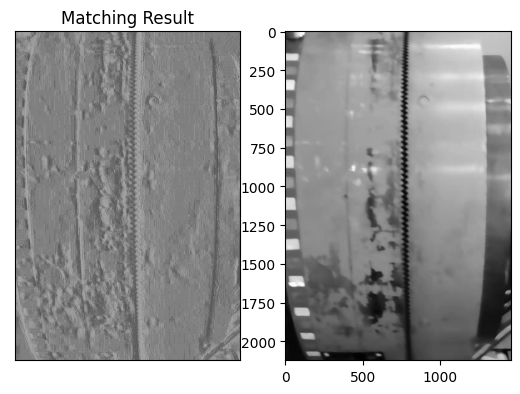

In [46]:

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')

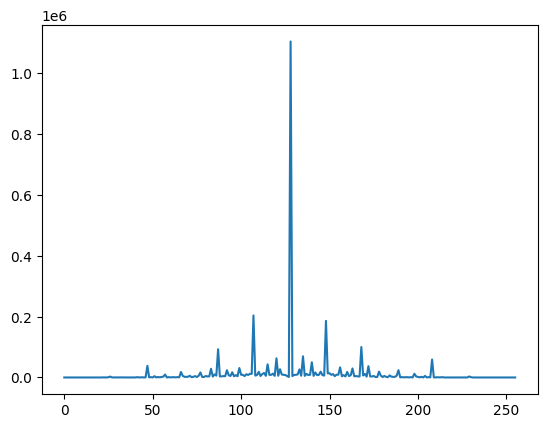

In [49]:
hist = cv2.calcHist([res], [0], None, [256], [-1, 1])
plt.plot(hist)

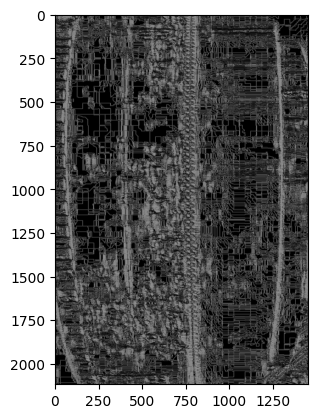

In [42]:
nres = np.absolute(res)
plt.imshow(nres, cmap='gray')